# Ensemble Learning: Boosting

In this notebook, we will explore boosting strategy. Boosting is mainly used to reduce the bias in a model. Examples of boosting algorithms are Ada-Boost, XGBoost, Gradient Boosted Decision Trees, etc. This notebook is adapted from [[1](#References)].


In [1]:
%matplotlib inline
import sqlite3, pandas as pd, numpy as np, nltk, string, matplotlib.pyplot as plt, seaborn as sns
import string, math, pickle
import warnings

warnings.filterwarnings("ignore")

from xgboost.sklearn import XGBModel, XGBRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import datasets

## Load Iris dataset

In [2]:
#Load Iris.csv into a pandas dataFrame.
iris_dataset = pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")
X, y = iris_dataset.iloc[:,0:4], iris_dataset.iloc[:,4]

from sklearn.preprocessing import LabelEncoder
encoder_object = LabelEncoder()
y = encoder_object.fit_transform(y)

### Boosting:

The second ensemble technique that we are going to discuss is called Boosting. Boosting, in general, is used to convert weak learners to strong ones.

Boosting involves training the weak learners iteratively, each trying to correct the error made by the previous model. This is achieved by training a weak model on the whole training data, then building a second model which aims at correcting the errors made by the first model. Then we build a third model that will correct the errors made by the second model and so on. Models are added iteratively until the final model has corrected all the errors made by all the previous models. When the models are added at each stage, some weights are assigned to the model related to accuracy. 

After a weak classifier is added, the weights are re-adjusted. The misclassified points are given a higher weight, and correctly classified points are assigned lower weights. Such an approach will make the next weak classifier focus on the errors made by the previous model. 

Boosting reduces generalization error by taking a high-bias & low-variance model and reducing the bias by a significant level. Remember, bagging reduces variance. Similar to bagging, boosting also lets us work with both classification and regression models. 

The below diagram shows how boosting works at each of the stages intuitively. 

<tr>
<td> <img src="../images/BoostingFINAL.jpg"> </td>
</tr>

Let's understand the above diagram with an example. Suppose we are given a dataset D; we train a model on the whole dataset at stage 0. The model may be either a classification or a regression model. Let's name this model M_0. Let us assume this model M_0 is trying to fit a function h_0(x). Thus the prediction function for this model is given by y_pred=h_0(x). Model 0 is designed to have a high bias. Generally, boosting is applied for a high bias and low variance model. High bias arises mostly due to some incorrect assumptions made at the training stage. 

Now, after building the first model, we will, at stage 0, get the error in prediction for each data point made by the model M_0. So, the error in the prediction for any class label is given by y-y_pred. Remember, there are lots of lots of error functions out there - for example, the squared error, the hinge loss error, the logistic loss error etc. But, for simplicity, I have taken a simple difference error for this example. Now that we have done these things in stage 0, what we will do in stage 1 is as follows. I will try fit a model M_1 on the errors produced by the model at stage 0. Remember, M_1 is not training on the actual class labels. M_1 is training on the errors we have got at the end of stage 0. Let's say we get a function h_1(x), which has trained on the errors generated by model M_0. Thus at the end of stage 1, my final model will actually be the weighted sum of the previous two prediction functions (as shown in the diagram). We will assign weights a_0 and a_1 to h_0(x) and h_1(x), respectively. Thus at the end of stage 1, the model looks like this : F_1(x) = a_0 * h_0(x) + a_1 * h_1(x), where a_0 and a_1 are weights assigned to the prediction functions. Remember, the weights will always be higher for functions which has a high misclassification error. In this way, we can make the next model in the sequence to focus more on the errors made by the previous model. Similarly, the model at the end of stage 2 will have the function F_2(x) = a_0 * h_0(x) + a_1 * h_1(x) + a_2 * h_2(x). Thus at the end of all stages, the final model that we have is given by the summation of a_i * h_x(i), where the value of i ranges from 1 to N. Thus, intuitively, if we think we are actually reducing the training error which means in other words we are actually reducing the bias of a model.

We will look at some of the most popular boosting classifiers in the below code sample. We will also see how using boosting increases the overall accuracy in prediction using an EnsembleVoteClassifier. EnsembleVoteClassifier is a very powerful class available in the MLEXTEND package, which is used to combine the predictions of different machine learning models by using the concept of majority voting. The EnsembleVoteClassifier implements two types of voting approach - "hard" and "soft". In a "hard" voting approach we will predict the class label of the final model based on the majority vote obtained from all the base classifiers. For example, if 7 out of 10 base learners predicts the class label to be "Yes" in a binary classification problem, we will take "Yes" to be the final class label of the final ensemble model. In soft voting, we predict the class labels by averaging the class-probabilities. Anyway, in the below example we see that the accuracy increases to 0.967 (when we use boosted classifiers with majority voting) as compared to the highest accuracy of an individual model which was 0.961, although the increase is very slight. Still, you got my point!  

In [3]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

ada_boost = AdaBoostClassifier(n_estimators=5)
grad_boost = GradientBoostingClassifier(n_estimators=10)
xgb_boost = XGBClassifier(max_depth=5, learning_rate=0.001, eval_metric='mlogloss')

ensemble_clf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')
boosting_labels = ['Ada Boost', 'Gradient Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, grad_boost, xgb_boost, ensemble_clf], boosting_labels):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: {0:.3f}, Variance: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Accuracy: 0.967, Variance: (+/-) 0.009 [Ada Boost]
Accuracy: 0.960, Variance: (+/-) 0.016 [Gradient Boost]
Accuracy: 0.973, Variance: (+/-) 0.009 [XG Boost]
Accuracy: 0.973, Variance: (+/-) 0.009 [Ensemble]


In [4]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

ada_boost = AdaBoostClassifier(n_estimators=5)
grad_boost = GradientBoostingClassifier(n_estimators=10)
xgb_boost = XGBClassifier(max_depth=5, learning_rate=0.001, eval_metric='mlogloss')

ensemble_clf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')
boosting_labels = ['Ada Boost', 'Gradient Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, grad_boost, xgb_boost, ensemble_clf], boosting_labels):
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: {0:.3f}, Variance: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Accuracy: 0.967, Variance: (+/-) 0.009 [Ada Boost]
Accuracy: 0.960, Variance: (+/-) 0.016 [Gradient Boost]
Accuracy: 0.973, Variance: (+/-) 0.009 [XG Boost]
Accuracy: 0.973, Variance: (+/-) 0.009 [Ensemble]


Here, we look at the decision boundaries by each boosted classifiers, and how all the three base models classify the data over a region. We will also take a look at the decision region generated by the voting classifier. In the MLEXTEND package, there is a very powerful library called "plot_decision_regions" which can be used to visually see the decision regions for different classifiers. Anyway, in the below example I have trained and fitted the model to two of the most important features, i.e. "petal_length" and "petal_width". 

In [5]:
#Decision Regions for all the boosting algorithms.
X = np.array(iris_dataset[['petal_length','petal_width']])
y = np.array(y)

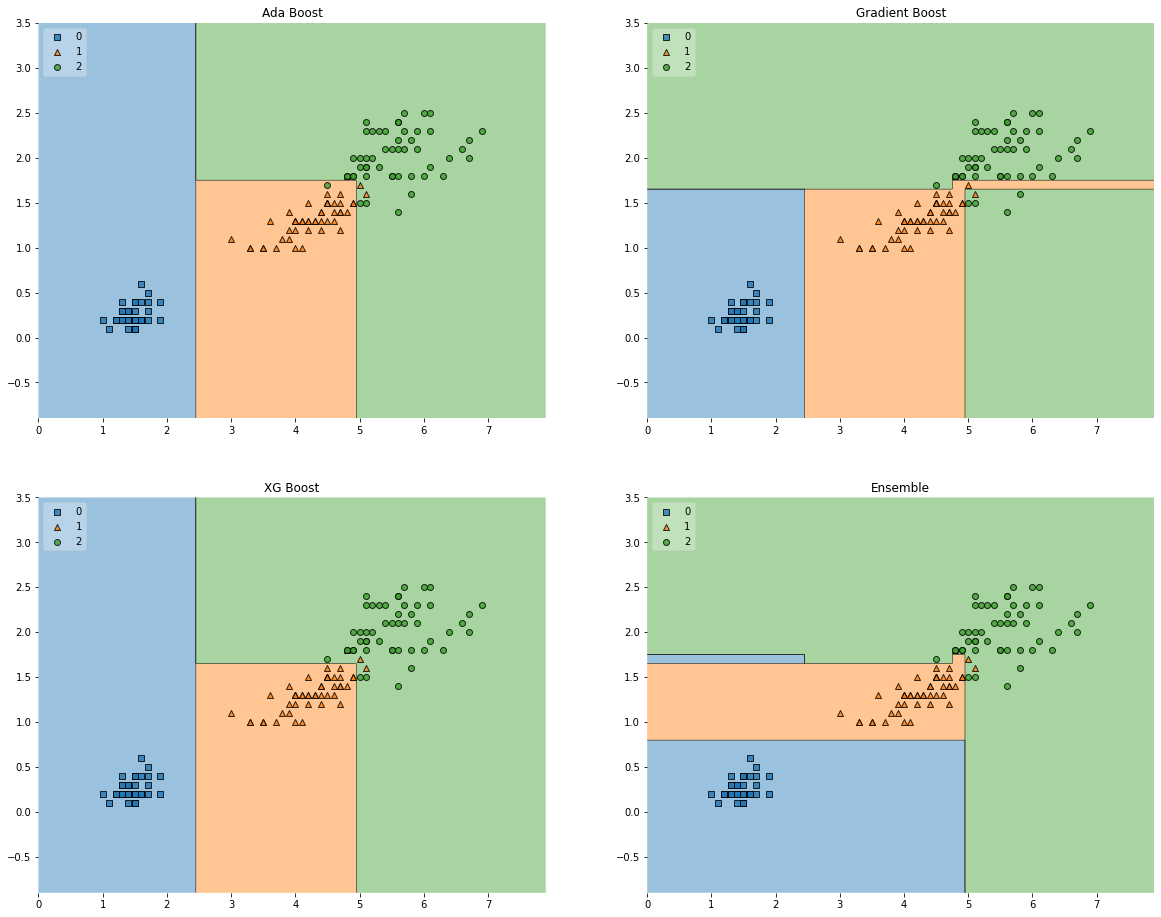

In [6]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(20,16))

for clf, label, grd in zip([ada_boost, grad_boost, xgb_boost, ensemble_clf], 
                           boosting_labels, itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

# References

[1] S. Paual. [Ensemble Learning — Bagging, Boosting, Stacking and Cascading Classifiers in Machine Learning using SKLEARN and MLEXTEND libraries](https://medium.com/@saugata.paul1010/ensemble-learning-bagging-boosting-stacking-and-cascading-classifiers-in-machine-learning-9c66cb271674) 